Mounted at /content/drive
Covariance matrix :

          IR0_meas  IR1_meas  IR2_meas  IR3_meas   IR0_cam   IR1_cam  \
IR0_meas  1.000000 -0.366704 -0.813940  0.161024 -0.796964  0.521238   
IR1_meas -0.366704  1.000000  0.381991 -0.657423  0.315474 -0.850780   
IR2_meas -0.813940  0.381991  1.000000 -0.216693  0.731488 -0.426498   
IR3_meas  0.161024 -0.657423 -0.216693  1.000000  0.019265  0.553010   
IR0_cam  -0.796964  0.315474  0.731488  0.019265  1.000000 -0.489408   
IR1_cam   0.521238 -0.850780 -0.426498  0.553010 -0.489408  1.000000   
IR2_cam   0.754982 -0.332833 -0.916373  0.212426 -0.729220  0.383368   
IR3_cam  -0.055683  0.495842  0.110762 -0.820627 -0.127835 -0.455322   

           IR2_cam   IR3_cam  
IR0_meas  0.754982 -0.055683  
IR1_meas -0.332833  0.495842  
IR2_meas -0.916373  0.110762  
IR3_meas  0.212426 -0.820627  
IR0_cam  -0.729220 -0.127835  
IR1_cam   0.383368 -0.455322  
IR2_cam   1.000000 -0.128439  
IR3_cam  -0.128439  1.000000  


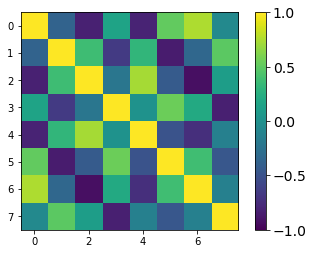

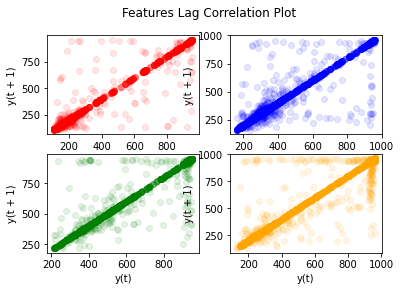

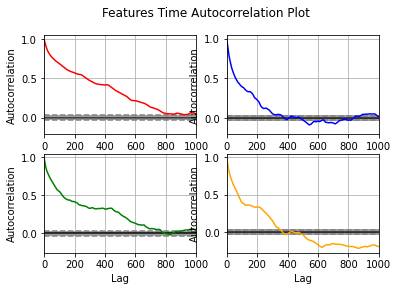

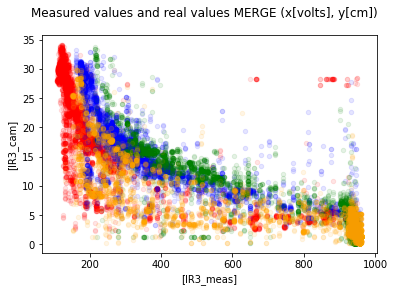

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from google.colab import drive
drive.mount('/content/drive')

tf.random.set_seed(42)

dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_0312.csv', sep=",")

# Train/Test split
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# X / Y split
X_train = train_dataset.drop(['IR0_cam','IR1_cam','IR2_cam','IR3_cam'], axis=1)
Y_train = train_dataset.drop(['IR0_meas','IR1_meas','IR2_meas','IR3_meas'], axis=1)
X_test = test_dataset.drop(['IR0_cam','IR1_cam','IR2_cam','IR3_cam'], axis=1)
Y_test = test_dataset.drop(['IR0_meas','IR1_meas','IR2_meas','IR3_meas'], axis=1)

# Stacking
X_train_stack = X_train.stack()
Y_train_stack = Y_train.stack()
X_test_stack = X_test.stack()
Y_test_stack = Y_test.stack()

# https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

corrM = dataset.corr()
print('Covariance matrix :\n')
# print(corrM.iloc[4::,0:4])
print(corrM)
# plt.imshow(corrM.iloc[4::,0:4],vmin=-1, vmax=1)
plt.imshow(corrM,vmin=-1, vmax=1)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

# fig, axes = plt.subplots(nrows=2, ncols=2)
# fig.suptitle('Measured values and real values SEPARATE (x[volts], y[cm])')
# dataset.plot(ax=axes[0,0],x="IR0_meas", y=["IR0_cam"],kind ="scatter", color="red", alpha=0.1)
# dataset.plot(ax=axes[0,1],x="IR1_meas", y=["IR1_cam"],kind ="scatter", color="blue", alpha=0.1)
# dataset.plot(ax=axes[1,0],x="IR2_meas", y=["IR2_cam"],kind ="scatter", color="green", alpha=0.1)
# dataset.plot(ax=axes[1,1],x="IR3_meas", y=["IR3_cam"],kind ="scatter", color="orange", alpha=0.1)
# plt.show()

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle('Features Lag Correlation Plot')
# dataset["IR0_meas"].lagplot(ax=axes[0,0], color="red", alpha=0.1)
lag_plot(dataset["IR0_meas"], ax=axes[0,0], c="red", alpha=0.1)
lag_plot(dataset["IR1_meas"], ax=axes[0,1], c="blue", alpha=0.1)
lag_plot(dataset["IR2_meas"], ax=axes[1,0], c="green", alpha=0.1)
lag_plot(dataset["IR3_meas"], ax=axes[1,1], c="orange", alpha=0.1)
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle('Features Time Autocorrelation Plot')
# dataset["IR0_meas"].lagplot(ax=axes[0,0], color="red", alpha=0.1)
autocorrelation_plot(dataset["IR0_meas"], ax=axes[0,0], c="red", alpha=1).set_xlim([0, 1000])
autocorrelation_plot(dataset["IR1_meas"], ax=axes[0,1], c="blue", alpha=1).set_xlim([0, 1000])
autocorrelation_plot(dataset["IR2_meas"], ax=axes[1,0], c="green", alpha=1).set_xlim([0, 1000])
autocorrelation_plot(dataset["IR3_meas"], ax=axes[1,1], c="orange", alpha=1).set_xlim([0, 1000])
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle('Measured values and real values MERGE (x[volts], y[cm])')
dataset.plot(ax=ax,x=["IR0_meas"], y=["IR0_cam"],kind ="scatter", color="red", alpha=0.1)
dataset.plot(ax=ax,x=["IR1_meas"], y=["IR1_cam"],kind ="scatter", color="blue", alpha=0.1)
dataset.plot(ax=ax,x=["IR2_meas"], y=["IR2_cam"],kind ="scatter", color="green", alpha=0.1)
dataset.plot(ax=ax,x=["IR3_meas"], y=["IR3_cam"],kind ="scatter", color="orange", alpha=0.1)
plt.show()

# Polynomial Fit

In [2]:
n = 3 # Polynomial fit order
M_Polyfit_3 = np.poly1d(np.polyfit(X_train_stack, Y_train_stack, n))

n = 4 # Polynomial fit order
M_Polyfit_4 = np.poly1d(np.polyfit(X_train_stack, Y_train_stack, n))

n = 5 # Polynomial fit order
M_Polyfit_5 = np.poly1d(np.polyfit(X_train_stack, Y_train_stack, n))

n = 5 # Polynomial fit order
M_Polyfit_5_s0 = np.poly1d(np.polyfit(dataset["IR0_meas"], dataset["IR0_cam"], n))
M_Polyfit_5_s1 = np.poly1d(np.polyfit(dataset["IR1_meas"], dataset["IR1_cam"], n))
M_Polyfit_5_s2 = np.poly1d(np.polyfit(dataset["IR2_meas"], dataset["IR2_cam"], n))
M_Polyfit_5_s3 = np.poly1d(np.polyfit(dataset["IR3_meas"], dataset["IR3_cam"], n))


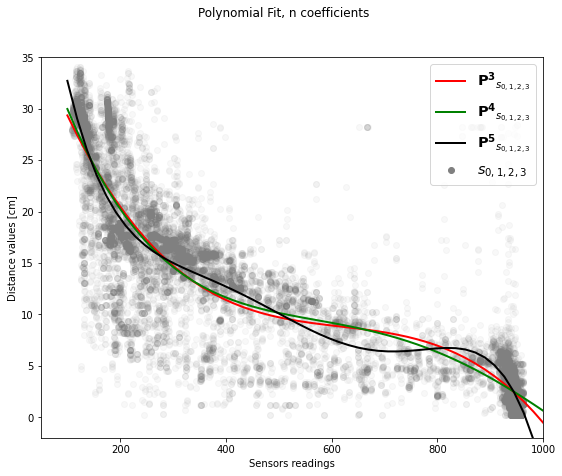

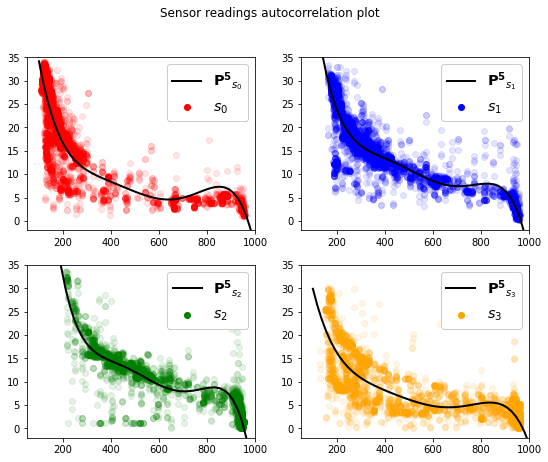

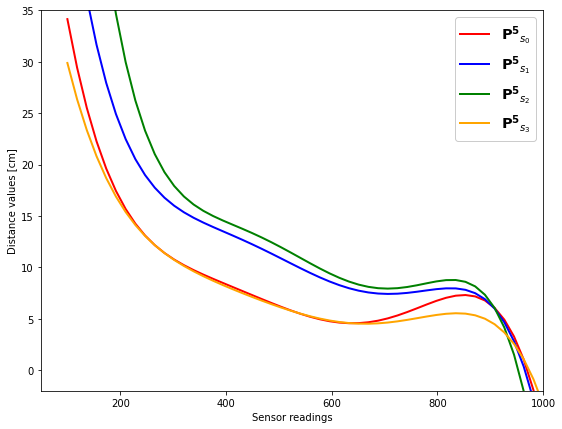

In [3]:

plt.rcParams["figure.figsize"] = (9,7)

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle('Polynomial Fit, n coefficients')
prod = ax.scatter(X_train_stack, Y_train_stack, color="grey", label=r'$s_{0,1,2,3}$')
ax.plot(np.linspace(100,1000,50),M_Polyfit_3(np.linspace(100,1000,50)), color = "red", linewidth = 2, label=r'$\mathbf{P^3}_{s_{0,1,2,3}}$')
ax.plot(np.linspace(100,1000,50),M_Polyfit_4(np.linspace(100,1000,50)), color = "green", linewidth = 2, label=r'$\mathbf{P^4}_{s_{0,1,2,3}}$')
ax.plot(np.linspace(100,1000,50),M_Polyfit_5(np.linspace(100,1000,50)), color = "black", linewidth = 2, label=r'$\mathbf{P^5}_{s_{0,1,2,3}}$')
ax.legend(loc='upper right', fontsize="x-large")
prod.set_alpha(0.05)
ax.set_xlim(50, 1000)
ax.set_ylim(-2, 35)
plt.xlabel("Sensors readings")
plt.ylabel("Distance values [cm]")
plt.savefig('polyfits_n345.png')
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle('Sensor readings autocorrelation plot')
axes[0,0].plot(np.linspace(100,1000,50),M_Polyfit_5_s0(np.linspace(100,1000,50)), color = "black", linewidth = 2, label=r'$\mathbf{P^{5}}_{s_{0}}$')
axes[0,1].plot(np.linspace(100,1000,50),M_Polyfit_5_s1(np.linspace(100,1000,50)), color = "black", linewidth = 2, label=r'$\mathbf{P^{5}}_{s_{1}}$')
axes[1,0].plot(np.linspace(100,1000,50),M_Polyfit_5_s2(np.linspace(100,1000,50)), color = "black", linewidth = 2, label=r'$\mathbf{P^{5}}_{s_{2}}$')
axes[1,1].plot(np.linspace(100,1000,50),M_Polyfit_5_s3(np.linspace(100,1000,50)), color = "black", linewidth = 2, label=r'$\mathbf{P^{5}}_{s_{3}}$')
l0 = axes[0,0].scatter(x=dataset["IR0_meas"], y=dataset["IR0_cam"], color="red", label=r'$s_0$')
l1 = axes[0,1].scatter(x=dataset["IR1_meas"], y=dataset["IR1_cam"], color="blue", label=r'$s_1$')
l2 = axes[1,0].scatter(x=dataset["IR2_meas"], y=dataset["IR2_cam"], color="green", label=r'$s_2$')
l3 = axes[1,1].scatter(x=dataset["IR3_meas"], y=dataset["IR3_cam"], color="orange", label=r'$s_3$')

for _ in axes:
    for i in _:
        i.legend(loc="upper right", framealpha=1, fontsize="x-large")
        i.set_xlim(50, 1000)
        i.set_ylim(-2, 35)

l0.set_alpha(0.1)
l1.set_alpha(0.1)
l2.set_alpha(0.1)
l3.set_alpha(0.1)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(np.linspace(100,1000,50),M_Polyfit_5_s0(np.linspace(100,1000,50)), color = "red", linewidth = 2, label=r'$\mathbf{P^{5}}_{s_{0}}$')
ax.plot(np.linspace(100,1000,50),M_Polyfit_5_s1(np.linspace(100,1000,50)), color = "blue", linewidth = 2, label=r'$\mathbf{P^{5}}_{s_{1}}$')
ax.plot(np.linspace(100,1000,50),M_Polyfit_5_s2(np.linspace(100,1000,50)), color = "green", linewidth = 2, label=r'$\mathbf{P^{5}}_{s_{2}}$')
ax.plot(np.linspace(100,1000,50),M_Polyfit_5_s3(np.linspace(100,1000,50)), color = "orange", linewidth = 2, label=r'$\mathbf{P^{5}}_{s_{3}}$')
ax.legend(loc="upper right", framealpha=1, fontsize="x-large")
ax.set_xlim(50, 1000)
ax.set_ylim(-2, 35)
plt.xlabel("Sensor readings")
plt.ylabel("Distance values [cm]")
plt.savefig('polyfits.png')
plt.show()


# SVM Regression

In [ ]:
from sklearn.svm import SVR
from sklearn.datasets import make_regression

# Create the SVR model
M_SVR = SVR(kernel="rbf")
M_SVR_s0 = SVR(kernel="rbf")
M_SVR_s1 = SVR(kernel="rbf")
M_SVR_s2 = SVR(kernel="rbf")
M_SVR_s3 = SVR(kernel="rbf")

M_SVR.fit( np.array(X_train_stack).reshape(-1, 1), np.ravel(np.array(Y_train_stack).reshape(-1, 1)))
M_SVR_s0.fit( np.array(dataset["IR0_meas"]).reshape(-1, 1), np.ravel(np.array(dataset["IR0_meas"]).reshape(-1, 1)))
M_SVR_s1.fit( np.array(dataset["IR1_meas"]).reshape(-1, 1), np.ravel(np.array(dataset["IR1_meas"]).reshape(-1, 1)))
M_SVR_s2.fit( np.array(dataset["IR2_meas"]).reshape(-1, 1), np.ravel(np.array(dataset["IR2_meas"]).reshape(-1, 1)))
M_SVR_s3.fit( np.array(dataset["IR3_meas"]).reshape(-1, 1), np.ravel(np.array(dataset["IR3_meas"]).reshape(-1, 1)))
# M_SVR_poly_deg3.fit( np.array(X_train_stack).reshape(-1, 1), np.ravel(np.array(Y_train_stack).reshape(-1, 1)))
# M_SVR_poly_deg4.fit( np.array(X_train_stack).reshape(-1, 1), np.ravel(np.array(Y_train_stack).reshape(-1, 1)))
# M_SVR_poly_deg5.fit( np.array(X_train_stack).reshape(-1, 1), np.ravel(np.array(Y_train_stack).reshape(-1, 1)))

SVR()

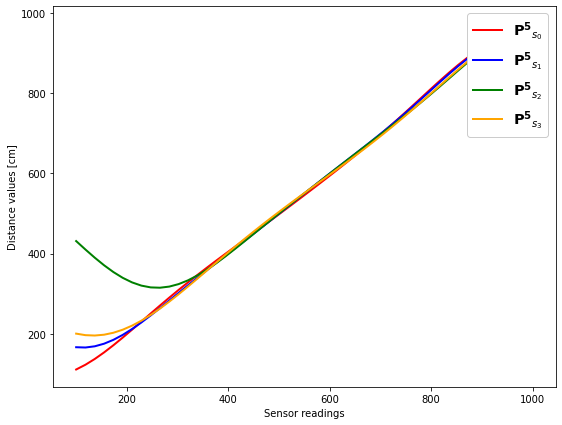

In [ ]:
prod = [M_SVR_s0,M_SVR_s1,M_SVR_s2,M_SVR_s3]
# x = [dataset["IR0_meas"],dataset["IR1_meas"],dataset["IR2_meas"], dataset["IR3_meas"]]
color=["red","blue","green","orange"]
i=0
fig, ax = plt.subplots(nrows=1, ncols=1)
# for each in prod :
#   # x = x[i]
#   x = np.linspace(100,1000,50)
#   y = each.predict(np.array(x).reshape(-1, 1))
#   ax.plot(x,y, color = color[i], linewidth = 2, label=r'$\mathbf{P^{5}}_{s_{1}}$')
#   i+=1


ax.plot(np.linspace(100,1000,50),M_SVR_s0.predict(np.linspace(100,1000,50).reshape(-1, 1)), color = "red", linewidth = 2, label=r'$\mathbf{P^{5}}_{s_{0}}$')
ax.plot(np.linspace(100,1000,50),M_SVR_s1.predict(np.linspace(100,1000,50).reshape(-1, 1)), color = "blue", linewidth = 2, label=r'$\mathbf{P^{5}}_{s_{1}}$')
ax.plot(np.linspace(100,1000,50),M_SVR_s2.predict(np.linspace(100,1000,50).reshape(-1, 1)), color = "green", linewidth = 2, label=r'$\mathbf{P^{5}}_{s_{2}}$')
ax.plot(np.linspace(100,1000,50),M_SVR_s3.predict(np.linspace(100,1000,50).reshape(-1, 1)), color = "orange", linewidth = 2, label=r'$\mathbf{P^{5}}_{s_{3}}$')
ax.legend(loc="upper right", framealpha=1, fontsize="x-large")
# ax.set_xlim(50, 1000)
# ax.set_ylim(-2, 35)
plt.xlabel("Sensor readings")
plt.ylabel("Distance values [cm]")
plt.savefig('polyfits.png')
plt.show()


# Classical approach
SISO Network trained on whole dataset, 1 input 1 output

In [23]:
# derived via grid search :
# learning_rate = [0.01, 0.005, 0.001], hidden_size = [10], batch_size = [5,10,20,25,30], epochs = [100,200]
# Best: 0.833185 using {'batch_size': 20, 'epochs': 100, 'model__hidden_size': 10, 'model__learning_rate': 0.01}

M_s0 = keras.Sequential([
  layers.Dense(1, input_dim=1),
  layers.Dense(10, activation='relu'),
  layers.Dense(units=1)
])
M_s0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03), loss='mean_absolute_error')

M_s1 = keras.Sequential([
  layers.Dense(1, input_dim=1),
  layers.Dense(10, activation='relu'),
  layers.Dense(units=1)
])
M_s1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03), loss='mean_absolute_error')

M_s2 = keras.Sequential([
  layers.Dense(1, input_dim=1),
  layers.Dense(10, activation='relu'),
  layers.Dense(units=1)
])
M_s2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03), loss='mean_absolute_error')

M_s3 = keras.Sequential([
  layers.Dense(1, input_dim=1),
  layers.Dense(10, activation='relu'),
  layers.Dense(units=1)
])
M_s3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03), loss='mean_absolute_error')

M_s0123 = keras.Sequential([
  layers.Dense(1, input_dim=1),
  layers.Dense(10, activation='relu'),
  layers.Dense(units=1)
])
M_s0123.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03), loss='mean_absolute_error')


history_M_s0 = M_s0.fit(dataset["IR0_meas"], dataset["IR0_cam"], epochs=30, verbose=0, validation_split = 0.15, batch_size=20)
history_M_s1 = M_s1.fit(dataset["IR1_meas"], dataset["IR1_cam"], epochs=30, verbose=0, validation_split = 0.15, batch_size=20)
history_M_s2 = M_s2.fit(dataset["IR2_meas"], dataset["IR2_cam"], epochs=30, verbose=0, validation_split = 0.15, batch_size=20)
history_M_s3 = M_s3.fit(dataset["IR3_meas"], dataset["IR3_cam"], epochs=30, verbose=0, validation_split = 0.15, batch_size=20)
history_M_s0123 = M_s0123.fit(X_train_stack, Y_train_stack, epochs=30, verbose=0, validation_split = 0.15, batch_size=20)

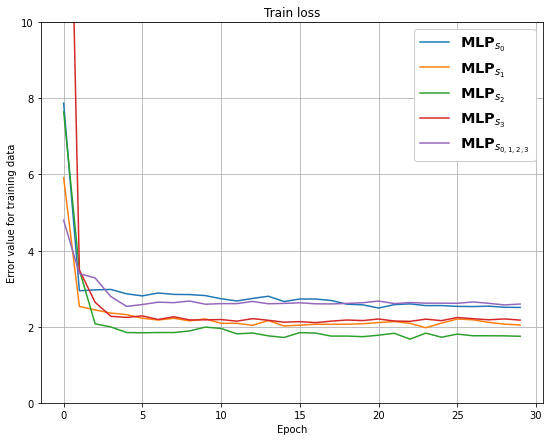

In [24]:
plt.title("Train loss")
plt.plot(history_M_s0.history['loss'], label=r'$\mathbf{MLP}_{s_{0}}$')
plt.plot(history_M_s1.history['loss'], label=r'$\mathbf{MLP}_{s_{1}}$')
plt.plot(history_M_s2.history['loss'], label=r'$\mathbf{MLP}_{s_{2}}$')
plt.plot(history_M_s3.history['loss'], label=r'$\mathbf{MLP}_{s_{3}}$')
plt.plot(history_M_s0123.history['loss'], label=r'$\mathbf{MLP}_{s_{0,1,2,3}}$')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error value for training data')
plt.legend(loc="upper right", framealpha=1, fontsize="x-large")
plt.grid(True)
plt.show()

# Using Transfert Learning

In [6]:
# https://androidkt.com/set-custom-weights-keras-using-numpy-array/

def get_w_and_b(model) :
  wb = []
  for each_layer in model.layers :
    weights = each_layer.get_weights()[0]
    biases = each_layer.get_weights()[1]
    wb.append((weights, biases))
  return np.asarray(wb,dtype=object)

def set_w_and_b(model, wb) :
  i=0
  for each_layer in model.layers :
    if i==0 :
      pass
    else :
      weights, bias = wb[i,:]
      each_layer.set_weights([weights,bias])
    i=i+1 

def create_model_SI_TL(training_features, training_labels, wb) : 

  model = keras.Sequential([
    layers.Dense(1, input_dim=1),
    layers.Dense(10, activation='relu'),
    layers.Dense(units=1)
  ])
  set_w_and_b(model, wb)
  # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss='mean_absolute_error')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mean_absolute_error')
  history = model.fit(training_features, training_labels, epochs=70, verbose=0, validation_split = 0.15, batch_size=20)
  
  # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_absolute_error')
  # history = fit_model_SI(model,training_features , training_labels)
  return model, history

In [7]:
wb_M_s0 = get_w_and_b(M_s0)
wb_M_s1 = get_w_and_b(M_s1)
wb_M_s2 = get_w_and_b(M_s2)
wb_M_s3 = get_w_and_b(M_s3)

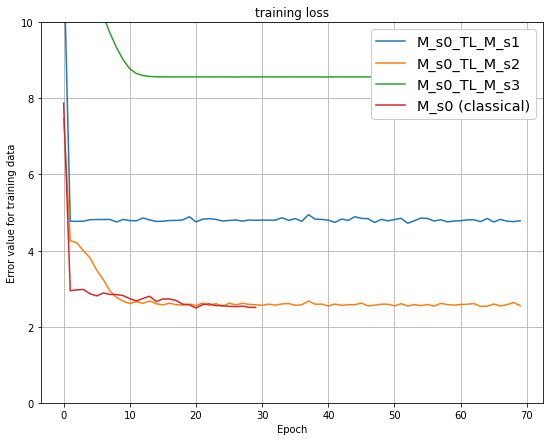

In [25]:
M_s0_TL_M_s1, history0M1 = create_model_SI_TL(dataset["IR0_meas"], dataset["IR0_cam"], wb = wb_M_s1)
M_s0_TL_M_s2, history0M2 = create_model_SI_TL(dataset["IR0_meas"], dataset["IR0_cam"], wb = wb_M_s2)
M_s0_TL_M_s3, history0M3 = create_model_SI_TL(dataset["IR0_meas"], dataset["IR0_cam"], wb = wb_M_s3)

plt.title("training loss")
plt.plot(history0M1.history['loss'], label='M_s0_TL_M_s1')
plt.plot(history0M2.history['loss'], label='M_s0_TL_M_s2')
plt.plot(history0M3.history['loss'], label='M_s0_TL_M_s3')
plt.plot(history_M_s0.history['loss'], label='M_s0 (classical)')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error value for training data')
plt.legend(loc="upper right", framealpha=1, fontsize="x-large")
plt.grid(True)
plt.show()

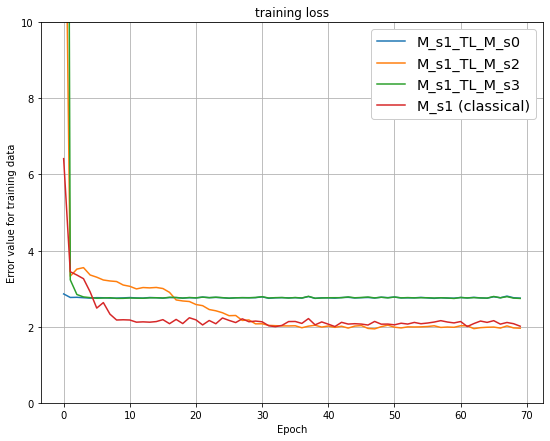

In [9]:
M_s1_TL_M_s0, history1M0 = create_model_SI_TL(dataset["IR1_meas"], dataset["IR1_cam"], wb = wb_M_s0)
M_s1_TL_M_s2, history1M2 = create_model_SI_TL(dataset["IR1_meas"], dataset["IR1_cam"], wb = wb_M_s2)
M_s1_TL_M_s3, history1M3 = create_model_SI_TL(dataset["IR1_meas"], dataset["IR1_cam"], wb = wb_M_s3)

plt.title("training loss")
plt.plot(history1M0.history['loss'], label='M_s1_TL_M_s0')
plt.plot(history1M2.history['loss'], label='M_s1_TL_M_s2')
plt.plot(history1M3.history['loss'], label='M_s1_TL_M_s3')
plt.plot(history_M_s1.history['loss'], label='M_s1 (classical)')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error value for training data')
plt.legend(loc="upper right", framealpha=1, fontsize="x-large")
plt.grid(True)
plt.show()

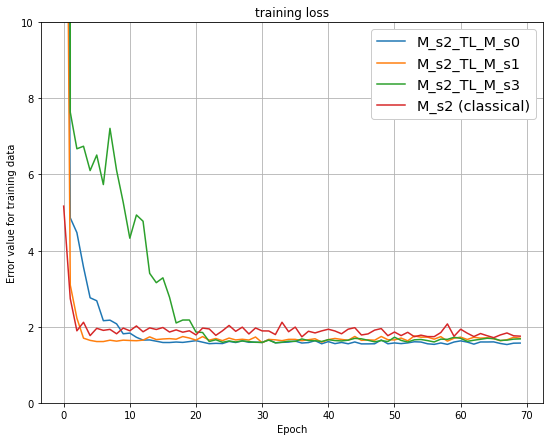

In [10]:
M_s2_TL_M_s0, history2M0 = create_model_SI_TL(dataset["IR2_meas"], dataset["IR2_cam"], wb = wb_M_s0)
M_s2_TL_M_s1, history2M1 = create_model_SI_TL(dataset["IR2_meas"], dataset["IR2_cam"], wb = wb_M_s1)
M_s2_TL_M_s3, history2M3 = create_model_SI_TL(dataset["IR2_meas"], dataset["IR2_cam"], wb = wb_M_s3)

plt.title("training loss")
plt.plot(history2M0.history['loss'], label='M_s2_TL_M_s0')
plt.plot(history2M1.history['loss'], label='M_s2_TL_M_s1')
plt.plot(history2M3.history['loss'], label='M_s2_TL_M_s3')
plt.plot(history_M_s2.history['loss'], label='M_s2 (classical)')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error value for training data')
plt.legend(loc="upper right", framealpha=1, fontsize="x-large")
plt.grid(True)
plt.show()

In [27]:
M_s3_TL_M_s0, history3M0 = create_model_SI_TL(dataset["IR3_meas"], dataset["IR3_cam"], wb = wb_M_s0)
M_s3_TL_M_s1, history3M1 = create_model_SI_TL(dataset["IR3_meas"], dataset["IR3_cam"], wb = wb_M_s1)
M_s3_TL_M_s2, history3M2 = create_model_SI_TL(dataset["IR3_meas"], dataset["IR3_cam"], wb = wb_M_s2)

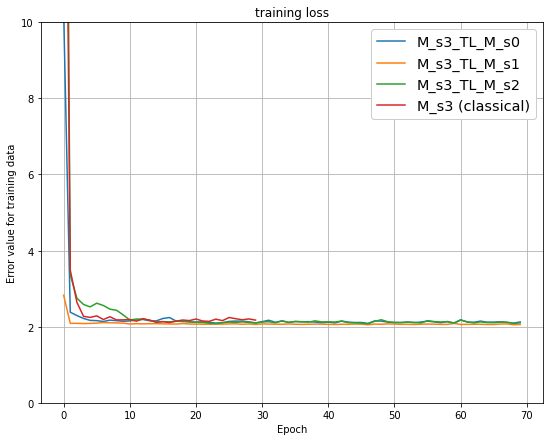

In [26]:
plt.title("training loss")
plt.plot(history3M0.history['loss'], label='M_s3_TL_M_s0')
plt.plot(history3M1.history['loss'], label='M_s3_TL_M_s1')
plt.plot(history3M2.history['loss'], label='M_s3_TL_M_s2')
plt.plot(history_M_s3.history['loss'], label='M_s3 (classical)')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error value for training data')
plt.legend(loc="upper right", framealpha=1, fontsize="x-large")
plt.grid(True)
plt.show()

# Time series adaptation

## Win = 3

In [12]:
x = ["IR0_meas", "IR1_meas", "IR2_meas", "IR3_meas" ]
y = ['IR0_cam','IR1_cam','IR2_cam','IR3_cam']
models = []
history =[]
for i in range(4) :
  # Temporal Train/Test split
  split_idx1 = int(len(dataset) * 0.7)
  split_idx2 = int(len(dataset) * 0.85)
  train_dataset_t = dataset.iloc[:split_idx1,]
  val_dataset_t = dataset.iloc[split_idx1:split_idx2,]
  test_dataset_t = dataset.iloc[split_idx2:,]

  X_train_t = train_dataset_t[x[i]]
  Y_train_t = train_dataset_t[y[i]]

  X_val_t = val_dataset_t[x[i]]
  Y_val_t = val_dataset_t[y[i]]

  X_test_t = test_dataset_t[x[i]]
  Y_test_t = test_dataset_t[y[i]]

  win_size = 3

  def split_sequence(sequence, win_size):
    X = []
    for i in range(len(sequence)):
      end_idx = i + win_size
      # exit condition
      if end_idx > len(sequence) - 1 :
        break
      # get X and Y values
      seq_x = sequence[i:end_idx]
      X.append(seq_x)
    return np.array(X)

  X_train_win = split_sequence(np.array(X_train_t), win_size = win_size)
  Y_train_win = np.array(Y_train_t)[:X_train_win.shape[0]]

  X_val_win = split_sequence(np.array(X_val_t), win_size = win_size)
  Y_val_win = np.array(Y_val_t)[:X_val_win.shape[0]]

  X_test_win = split_sequence(np.array(X_test_t), win_size = win_size)
  Y_test_win = np.array(Y_test_t)[:X_test_win.shape[0]]

  Mt_s = keras.Sequential([
    layers.Dense(win_size, input_dim=win_size),
    layers.Dense(10, activation='relu'),
    layers.Dense(units=1)
  ])

  Mt_s.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mean_absolute_error')

  history0 = Mt_s.fit(X_train_win, Y_train_win,validation_data=(X_val_win, Y_val_win), epochs=100, verbose=0, batch_size=25)
  models.append(Mt_s)
  history.append(history0)

Mt_s0_w3 = models[0]; Mt_s1_w3 = models[1]; Mt_s2_w3 = models[2]; Mt_s3_w3 = models[3]

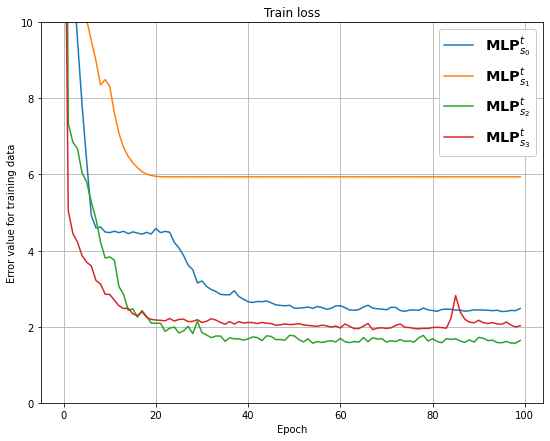

In [13]:
history_Mt_s0_w3 = history[0]
history_Mt_s1_w3 = history[1]
history_Mt_s2_w3 = history[2]
history_Mt_s3_w3 = history[3]

plt.title("Train loss")
plt.plot(history[0].history['loss'], label=r'$\mathbf{MLP}^t_{s_{0}}$')
plt.plot(history[1].history['loss'], label=r'$\mathbf{MLP}^t_{s_{1}}$')
plt.plot(history[2].history['loss'], label=r'$\mathbf{MLP}^t_{s_{2}}$')
plt.plot(history[3].history['loss'], label=r'$\mathbf{MLP}^t_{s_{3}}$')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error value for training data')
plt.legend(loc="upper right", framealpha=1, fontsize="x-large")
plt.grid(True)
plt.show()

## Win = 1

In [14]:
x = ["IR0_meas", "IR1_meas", "IR2_meas", "IR3_meas" ]
y = ['IR0_cam','IR1_cam','IR2_cam','IR3_cam']
models = []
history =[]
for i in range(4) :
  # Temporal Train/Test split
  split_idx1 = int(len(dataset) * 0.7)
  split_idx2 = int(len(dataset) * 0.85)
  train_dataset_t = dataset.iloc[:split_idx1,]
  val_dataset_t = dataset.iloc[split_idx1:split_idx2,]
  test_dataset_t = dataset.iloc[split_idx2:,]

  X_train_t = train_dataset_t[x[i]]
  Y_train_t = train_dataset_t[y[i]]

  X_val_t = val_dataset_t[x[i]]
  Y_val_t = val_dataset_t[y[i]]

  X_test_t = test_dataset_t[x[i]]
  Y_test_t = test_dataset_t[y[i]]

  win_size = 1

  def split_sequence(sequence, win_size):
    X = []
    for i in range(len(sequence)):
      end_idx = i + win_size
      # exit condition
      if end_idx > len(sequence) - 1 :
        break
      # get X and Y values
      seq_x = sequence[i:end_idx]
      X.append(seq_x)
    return np.array(X)

  X_train_win = split_sequence(np.array(X_train_t), win_size = win_size)
  Y_train_win = np.array(Y_train_t)[:X_train_win.shape[0]]

  X_val_win = split_sequence(np.array(X_val_t), win_size = win_size)
  Y_val_win = np.array(Y_val_t)[:X_val_win.shape[0]]

  X_test_win = split_sequence(np.array(X_test_t), win_size = win_size)
  Y_test_win = np.array(Y_test_t)[:X_test_win.shape[0]]

  Mt_s = keras.Sequential([
    layers.Dense(win_size, input_dim=win_size),
    layers.Dense(10, activation='relu'),
    layers.Dense(units=1)
  ])

  Mt_s.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mean_absolute_error')

  history0 = Mt_s.fit(X_train_win, Y_train_win,validation_data=(X_val_win, Y_val_win), epochs=100, verbose=0, batch_size=25)
  models.append(Mt_s)
  history.append(history0)

Mt_s0_w1 = models[0]; Mt_s1_w1 = models[1]; Mt_s2_w1 = models[2]; Mt_s3_w1 = models[3]

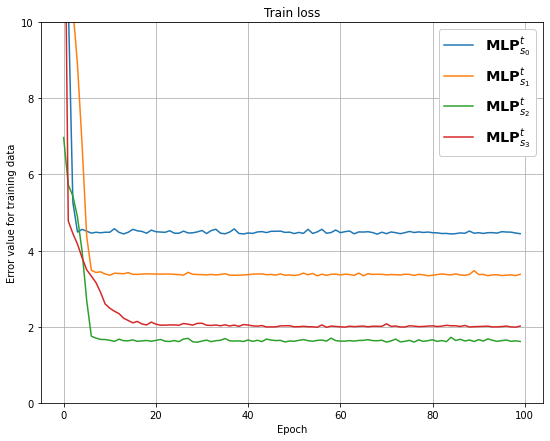

In [15]:
history_Mt_s0_w1 = history[0]
history_Mt_s1_w1 = history[1]
history_Mt_s2_w1 = history[2]
history_Mt_s3_w1 = history[3]

plt.title("Train loss")
plt.plot(history[0].history['loss'], label=r'$\mathbf{MLP}^t_{s_{0}}$')
plt.plot(history[1].history['loss'], label=r'$\mathbf{MLP}^t_{s_{1}}$')
plt.plot(history[2].history['loss'], label=r'$\mathbf{MLP}^t_{s_{2}}$')
plt.plot(history[3].history['loss'], label=r'$\mathbf{MLP}^t_{s_{3}}$')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error value for training data')
plt.legend(loc="upper right", framealpha=1, fontsize="x-large")
plt.grid(True)
plt.show()

## Win = 5

In [16]:
x = ["IR0_meas", "IR1_meas", "IR2_meas", "IR3_meas" ]
y = ['IR0_cam','IR1_cam','IR2_cam','IR3_cam']
models = []
history =[]
for i in range(4) :
  # Temporal Train/Test split
  split_idx1 = int(len(dataset) * 0.7)
  split_idx2 = int(len(dataset) * 0.85)
  train_dataset_t = dataset.iloc[:split_idx1,]
  val_dataset_t = dataset.iloc[split_idx1:split_idx2,]
  test_dataset_t = dataset.iloc[split_idx2:,]

  X_train_t = train_dataset_t[x[i]]
  Y_train_t = train_dataset_t[y[i]]

  X_val_t = val_dataset_t[x[i]]
  Y_val_t = val_dataset_t[y[i]]

  X_test_t = test_dataset_t[x[i]]
  Y_test_t = test_dataset_t[y[i]]

  win_size = 5

  def split_sequence(sequence, win_size):
    X = []
    for i in range(len(sequence)):
      end_idx = i + win_size
      # exit condition
      if end_idx > len(sequence) - 1 :
        break
      # get X and Y values
      seq_x = sequence[i:end_idx]
      X.append(seq_x)
    return np.array(X)

  X_train_win = split_sequence(np.array(X_train_t), win_size = win_size)
  Y_train_win = np.array(Y_train_t)[:X_train_win.shape[0]]

  X_val_win = split_sequence(np.array(X_val_t), win_size = win_size)
  Y_val_win = np.array(Y_val_t)[:X_val_win.shape[0]]

  X_test_win = split_sequence(np.array(X_test_t), win_size = win_size)
  Y_test_win = np.array(Y_test_t)[:X_test_win.shape[0]]

  Mt_s = keras.Sequential([
    layers.Dense(win_size, input_dim=win_size),
    layers.Dense(10, activation='relu'),
    layers.Dense(units=1)
  ])

  Mt_s.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mean_absolute_error')

  history0 = Mt_s.fit(X_train_win, Y_train_win,validation_data=(X_val_win, Y_val_win), epochs=100, verbose=0, batch_size=25)
  models.append(Mt_s)
  history.append(history0)

Mt_s0_w5 = models[0]; Mt_s1_w5 = models[1]; Mt_s2_w5 = models[2]; Mt_s3_w5 = models[3]

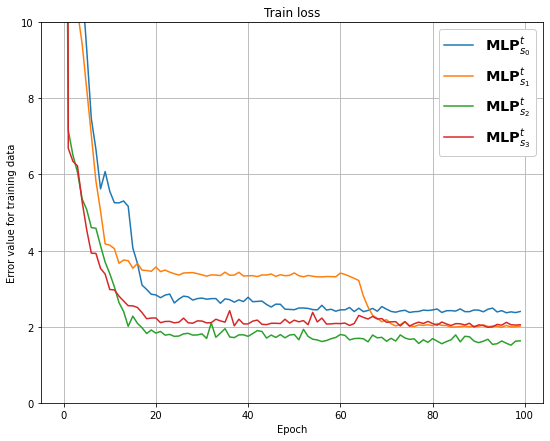

In [17]:
history_Mt_s0_w5 = history[0]
history_Mt_s1_w5 = history[1]
history_Mt_s2_w5 = history[2]
history_Mt_s3_w5 = history[3]

plt.title("Train loss")
plt.plot(history[0].history['loss'], label=r'$\mathbf{MLP}^t_{s_{0}}$')
plt.plot(history[1].history['loss'], label=r'$\mathbf{MLP}^t_{s_{1}}$')
plt.plot(history[2].history['loss'], label=r'$\mathbf{MLP}^t_{s_{2}}$')
plt.plot(history[3].history['loss'], label=r'$\mathbf{MLP}^t_{s_{3}}$')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error value for training data')
plt.legend(loc="upper right", framealpha=1, fontsize="x-large")
plt.grid(True)
plt.show()

# Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn import metrics

def create_model(hidden_size=10, learning_rate = 0.001) :
  model = keras.Sequential([
    layers.LSTM(win_size, input_shape=(1, win_size)),
    layers.Dense(hidden_size),
    layers.Dense(units=1)
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_absolute_error')
  return model

model = KerasRegressor(model=create_model, verbose=0, hidden_size=10, learning_rate = 0.001)

# param_grid = {
#     'learning_rate': [0.005],
#     "hidden_size": [10, 15, 20],
#     "epochs": [20, 50, 100, 200],
#     "batch_size": [25, 50, 75],
# }

# define the grid search parameters
learning_rate = [0.005]
batch_size = [20, 40, 80]
epochs = [100]
hidden_size = [10,5,20]
param_grid = dict(model__learning_rate = learning_rate, epochs=epochs, batch_size = batch_size, model__hidden_size = hidden_size)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv = 2 )

grid_result = grid.fit(X_train_win, Y_train_win,validation_data=(X_val_win, Y_val_win),verbose = 0)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']


for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.421435 using {'batch_size': 40, 'epochs': 100, 'model__hidden_size': 20, 'model__learning_rate': 0.005}
-0.101811 (0.031976) with: {'batch_size': 20, 'epochs': 100, 'model__hidden_size': 10, 'model__learning_rate': 0.005}
-0.078449 (0.012240) with: {'batch_size': 20, 'epochs': 100, 'model__hidden_size': 5, 'model__learning_rate': 0.005}
-0.065092 (0.038354) with: {'batch_size': 20, 'epochs': 100, 'model__hidden_size': 20, 'model__learning_rate': 0.005}
-0.071161 (0.028235) with: {'batch_size': 40, 'epochs': 100, 'model__hidden_size': 10, 'model__learning_rate': 0.005}
-0.083207 (0.021432) with: {'batch_size': 40, 'epochs': 100, 'model__hidden_size': 5, 'model__learning_rate': 0.005}
0.421435 (0.450907) with: {'batch_size': 40, 'epochs': 100, 'model__hidden_size': 20, 'model__learning_rate': 0.005}
-0.084056 (0.036181) with: {'batch_size': 80, 'epochs': 100, 'model__hidden_size': 10, 'model__learning_rate': 0.005}
-0.079114 (0.029259) with: {'batch_size': 80, 'epochs': 100, 'mod

In [ ]:
model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])

# LSTM

In [ ]:
# Temporal Train/Test split
split_idx1 = int(len(dataset) * 0.7)
split_idx2 = int(len(dataset) * 0.85)
train_dataset_t = dataset.iloc[:split_idx1,]
val_dataset_t = dataset.iloc[split_idx1:split_idx2,]
test_dataset_t = dataset.iloc[split_idx2:,]

X_train_t = train_dataset_t['IR0_meas']
Y_train_t = train_dataset_t['IR0_cam']

X_val_t = val_dataset_t['IR0_meas']
Y_val_t = val_dataset_t['IR0_cam']

X_test_t = test_dataset_t['IR0_meas']
Y_test_t = test_dataset_t['IR0_cam']


win_size = 10

def split_sequence(sequence, win_size):
  X = []
  for i in range(len(sequence)):
    end_idx = i + win_size
    # exit condition
    if end_idx > len(sequence) - 1 :
      break
    # get X and Y values
    seq_x = sequence[i:end_idx]
    X.append(seq_x)
  return np.array(X)

X_train_win = split_sequence(np.array(X_train_t), win_size = win_size)
Y_train_win = np.array(Y_train_t)[:X_train_win.shape[0]]

X_val_win = split_sequence(np.array(X_val_t), win_size = win_size)
Y_val_win = np.array(Y_val_t)[:X_val_win.shape[0]]

X_test_win = split_sequence(np.array(X_test_t), win_size = win_size)
Y_test_win = np.array(Y_test_t)[:X_test_win.shape[0]]

# reshape input to be [samples, time steps, features]
X_train_win = np.reshape(X_train_win, (X_train_win.shape[0], 1, X_train_win.shape[1]))
X_val_win = np.reshape(X_val_win, (X_val_win.shape[0], 1, X_val_win.shape[1]))
X_test_win = np.reshape(X_test_win, (X_test_win.shape[0], 1, X_test_win.shape[1]))

In [ ]:
M0_LSTM = keras.Sequential([
  layers.LSTM(win_size, input_shape=(1, win_size), return_sequences=True),
  layers.LSTM(10, return_sequences=True),
  layers.Dense(units=1)
])

M0_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mean_absolute_error')

history = M0_LSTM.fit(X_train_win, Y_train_win,validation_data=(X_val_win, Y_val_win), epochs=100, verbose=0, batch_size=100)

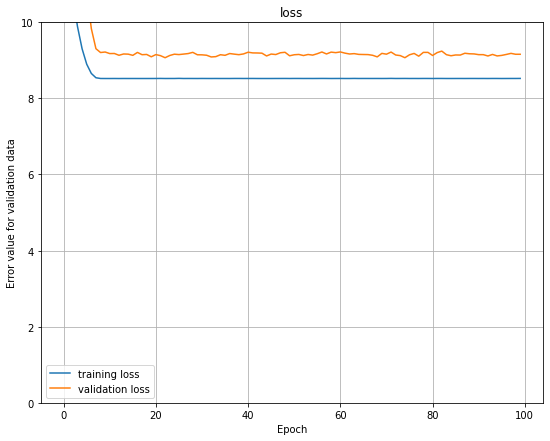

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.title("loss")
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error value for validation data')
plt.legend()
plt.grid(True)
plt.show()

# Performances

In [33]:
import sklearn.metrics

# https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

def error_calc(models_under_tests, test_Xs, test_Ys, names) :
  maelist = []
  r2list = []
  for i in range(len(models_under_tests)):
    model = models_under_tests[i]
    name = names[i]
    test_X = test_Xs[i]
    test_Y = test_Ys[i]

    # Predict test values
    if type(model) == np.poly1d :
      predicted_X = model(test_X)
    else :
      predicted_X = model.predict(test_X)
    # print(type(model) == np.poly1d)

    # MAE (Mean Absolute Error) computation
    mae = sklearn.metrics.mean_absolute_error(test_Y, predicted_X)

    # r2 score computation
    r2 = sklearn.metrics.r2_score(test_Y, predicted_X)

    maelist.append(mae)
    r2list.append(r2)

  dict = {'name': names, 'mae': maelist, 'r2': r2list} 
  df = pd.DataFrame(dict)
  return df

def error_calc_win(models_under_tests, names, string, string2) :
  split_idx2 = int(len(dataset) * 0.85)
  X = np.array(dataset[[string]].iloc[split_idx2:])
  Y = np.array(dataset[[string2]].iloc[split_idx2:])
  win_size=5
  X_train_win_5 = split_sequence(np.array(X), win_size = win_size)
  Y_train_win_5 = np.array(Y)[:X_train_win.shape[0]]
  win_size=3
  X_train_win_3 = split_sequence(np.array(X), win_size = win_size)
  Y_train_win_3 = np.array(Y)[:X_train_win.shape[0]]
  win_size=1
  X_train_win_1 = split_sequence(np.array(X), win_size = win_size)
  Y_train_win_1 = np.array(Y)[:X_train_win.shape[0]]

  pred_Mt_s0_w5 = models_under_tests[0].predict(X_train_win_5)
  pred_Mt_s0_w3 = models_under_tests[1].predict(X_train_win_3)
  pred_Mt_s0_w1 = models_under_tests[2].predict(X_train_win_1)

  mae_Mt_s0_w5 = sklearn.metrics.mean_absolute_error(Y[:-5], pred_Mt_s0_w5)
  mae_Mt_s0_w3 = sklearn.metrics.mean_absolute_error(Y[:-3], pred_Mt_s0_w3)
  mae_Mt_s0_w1 = sklearn.metrics.mean_absolute_error(Y[:-1], pred_Mt_s0_w1)
  maelist= [mae_Mt_s0_w5,mae_Mt_s0_w3,mae_Mt_s0_w1]

  r2_Mt_s0_w5 = sklearn.metrics.r2_score(Y[:-5], pred_Mt_s0_w5)
  r2_Mt_s0_w3 = sklearn.metrics.r2_score(Y[:-3], pred_Mt_s0_w3)
  r2_Mt_s0_w1 = sklearn.metrics.r2_score(Y[:-1], pred_Mt_s0_w1)
  r2list = [r2_Mt_s0_w5,r2_Mt_s0_w3,r2_Mt_s0_w1]
  
  dict = {'name': names, 'mae': maelist, 'r2': r2list} 
  df = pd.DataFrame(dict)

  return df

# classical nn:
models_under_tests = [M_s0, M_s1, M_s2, M_s3, M_s0123]
test_Xs = [X_test['IR0_meas'], X_test['IR1_meas'], X_test['IR2_meas'], X_test['IR3_meas'], X_test_stack]
test_Ys = [Y_test['IR0_cam'], Y_test['IR1_cam'], Y_test['IR2_cam'], Y_test['IR3_cam'], Y_test_stack]
names = ["M_s0", "M_s1", "M_s2", "M_s3", "M_s0123"]

df_classical_nn = error_calc(models_under_tests,test_Xs,test_Ys,names)

# TL s0
models_under_tests = [M_s0,M_s0_TL_M_s1, M_s0_TL_M_s2, M_s0_TL_M_s3]
test_Xs = [X_test['IR0_meas'],X_test['IR0_meas'],X_test['IR0_meas'],X_test['IR0_meas']]
test_Ys = [Y_test['IR0_cam'],Y_test['IR0_cam'],Y_test['IR0_cam'],Y_test['IR0_cam']]
names = ["M_s0", "M_s0_TL_M_s1", "M_s0_TL_M_s2", "M_s0_TL_M_s3"]
df_TL_nn_s0 = error_calc(models_under_tests,test_Xs,test_Ys,names)

# # TL s1
models_under_tests = [M_s1,M_s1_TL_M_s0, M_s1_TL_M_s2, M_s1_TL_M_s3]
test_Xs = [X_test['IR1_meas'],X_test['IR1_meas'],X_test['IR1_meas'],X_test['IR1_meas']]
test_Ys = [Y_test['IR1_cam'],Y_test['IR1_cam'],Y_test['IR1_cam'],Y_test['IR1_cam']]
names = ["M_s1", "M_s1_TL_M_s0", "M_s1_TL_M_s2", "M_s1_TL_M_s3"]
df_TL_nn_s1 = error_calc(models_under_tests,test_Xs,test_Ys,names)

# # TL s2
models_under_tests = [M_s2,M_s2_TL_M_s0, M_s2_TL_M_s1, M_s2_TL_M_s3]
test_Xs = [X_test['IR2_meas'],X_test['IR2_meas'],X_test['IR2_meas'],X_test['IR2_meas']]
test_Ys = [Y_test['IR2_cam'],Y_test['IR2_cam'],Y_test['IR2_cam'],Y_test['IR2_cam']]
names = ["M_s2", "M_s2_TL_M_s0", "M_s2_TL_M_s1", "M_s2_TL_M_s3"]
df_TL_nn_s2 = error_calc(models_under_tests,test_Xs,test_Ys,names)

# # TL s3
models_under_tests = [M_s3,M_s3_TL_M_s0, M_s3_TL_M_s1, M_s3_TL_M_s2]
test_Xs = [X_test['IR3_meas'],X_test['IR3_meas'],X_test['IR3_meas'],X_test['IR3_meas']]
test_Ys = [Y_test['IR3_cam'],Y_test['IR3_cam'],Y_test['IR3_cam'],Y_test['IR3_cam']]
names = ["M_s3", "M_s3_TL_M_s0", "M_s3_TL_M_s1", "M_s3_TL_M_s2"]
df_TL_nn_s3 = error_calc(models_under_tests,test_Xs,test_Ys,names)

# # polynomial fit
models_under_tests = [M_Polyfit_5_s0,M_Polyfit_5_s1,M_Polyfit_5_s2,M_Polyfit_5_s3,M_Polyfit_3,M_Polyfit_4,M_Polyfit_5]
test_Xs = [X_test['IR0_meas'], X_test['IR1_meas'], X_test['IR2_meas'], X_test['IR3_meas'], X_test_stack, X_test_stack, X_test_stack]
test_Ys = [Y_test['IR0_cam'], Y_test['IR1_cam'], Y_test['IR2_cam'], Y_test['IR3_cam'], Y_test_stack, Y_test_stack, Y_test_stack]
names = ['M_Polyfit_5_s0','M_Polyfit_5_s1','M_Polyfit_5_s2','M_Polyfit_5_s3','M_Polyfit_3','M_Polyfit_4','M_Polyfit_5']

df_poly = error_calc(models_under_tests,test_Xs,test_Ys,names)

# # TODO
models_under_tests = [Mt_s0_w5,Mt_s0_w3,Mt_s0_w1]
names = ["Mt_s0_w5","Mt_s0_w3","Mt_s0_w1"]
string = 'IR0_meas'
string2 = 'IR0_cam'
df_s0 = error_calc_win(models_under_tests,names,string,string2)

models_under_tests = [Mt_s1_w5,Mt_s1_w3,Mt_s1_w1]
names = ["Mt_s1_w5","Mt_s1_w3","Mt_s1_w1"]
string = 'IR1_meas'
string2 = 'IR1_cam'
df_s1 = error_calc_win(models_under_tests,names,string,string2)

models_under_tests = [Mt_s2_w5,Mt_s2_w3,Mt_s2_w1]
names = ["Mt_s2_w5","Mt_s2_w3","Mt_s2_w1"]
string = 'IR2_meas'
string2 = 'IR2_cam'
df_s2 = error_calc_win(models_under_tests,names,string,string2)

models_under_tests = [Mt_s3_w5,Mt_s3_w3,Mt_s3_w1]
names = ["Mt_s3_w5","Mt_s3_w3","Mt_s3_w1"]
string = 'IR3_meas'
string2 = 'IR3_cam'
df_s3 = error_calc_win(models_under_tests,names,string,string2)


# dict = {'name': names, 'mae': maelist, 'r2': r2list} 
# df = pd.DataFrame(dict)
print(df_s0)
print(df_s1)
print(df_s2)
print(df_s3)
print(df_TL_nn_s0)
print(df_TL_nn_s1)
print(df_TL_nn_s2)
print(df_TL_nn_s3)


print(df_poly)
print(df_classical_nn)




# print(df)

36/36 [==============================] - 0s 2ms/step
       name       mae        r2
0  Mt_s0_w5  1.889383  0.776546
1  Mt_s0_w3  2.024004  0.743218
2  Mt_s0_w1  5.001977  0.323212
       name       mae        r2
0  Mt_s1_w5  1.812476  0.889156
1  Mt_s1_w3  6.142989 -0.411243
2  Mt_s1_w1  2.276438  0.780448
       name       mae        r2
0  Mt_s2_w5  1.248926 -0.000025
1  Mt_s2_w3  1.420652 -0.477369
2  Mt_s2_w1  1.239222 -0.039733
       name       mae        r2
0  Mt_s3_w5  3.628996  0.493024
1  Mt_s3_w3  2.415897  0.752056
2  Mt_s3_w1  2.661512  0.656297
           name       mae        r2
0          M_s0  2.291110  0.823572
1  M_s0_TL_M_s1  4.618455  0.625630
2  M_s0_TL_M_s2  2.413833  0.807884
3  M_s0_TL_M_s3  8.385425 -0.000374
           name       mae        r2
0          M_s1  2.133389  0.822759
1  M_s1_TL_M_s0  2.716653  0.764755
2  M_s1_TL_M_s2  1.892577  0.815557
3  M_s1_TL_M_s3  2.725855  0.764534
           name       mae        r2
0          M_s2  1.578125  0.847736
1  

In [1]:
poly = np.array(df_poly.drop(columns=["r2","name"]).iloc[0:4])
classic = np.array(df_classical_nn.drop(columns=["r2","name"]).iloc[0:4])
concat = np.concatenate([poly,classic],axis = 1)
names = np.array(["s0","s1","s2","s3"])
cols = [ "polyfit","MLP"]

df = pd.DataFrame(concat, columns = cols, index = names)
df

# df_poly.drop(columns=["r2"]).iloc[0:4]
# df_classical_nn.drop(columns=["r2"])

NameError: ignored

# Final tests

7/7 [==============================] - 0s 3ms/step
1.143748178355483 0.9575945938110351 1.1912482280242138


Text(54.125, 0.5, 'Distance values [cm]')

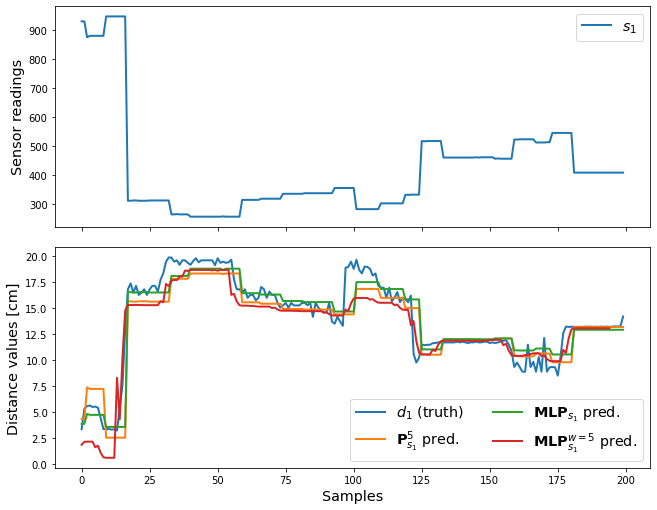

In [19]:
import sklearn.metrics

def split_sequence(sequence, win_size):
  X = []
  for i in range(len(sequence)):
    end_idx = i + win_size
    # exit condition
    if end_idx > len(sequence) - 1 :
      break
    # get X and Y values
    seq_x = sequence[i:end_idx]
    X.append(seq_x)
  return np.array(X)


# Generate testing data
X = np.array(dataset[['IR1_meas']].iloc[1100:1300])
Y = np.array(dataset[['IR1_cam']].iloc[1100:1300])
win_size=5
X_train_win = split_sequence(np.array(X), win_size = win_size)
Y_train_win = np.array(Y)[:X_train_win.shape[0]]

# # Generate Predictions
poly = M_Polyfit_5_s1
pred_Y_poly = poly(X)
MLP = M_s1
pred_Y_MLP = MLP.predict(X)
MLP_win = Mt_s1_w5
pred_Y_MLP_win = MLP_win.predict(X_train_win)

# # Metrics computations
mae_poly = sklearn.metrics.mean_absolute_error(Y, pred_Y_poly)
mae_MLP = sklearn.metrics.mean_absolute_error(Y, pred_Y_MLP)
mae_MLP_win = sklearn.metrics.mean_absolute_error(Y[:-win_size], pred_Y_MLP_win)
print(mae_poly,mae_MLP,mae_MLP_win)

# Plot
fig, axs = plt.subplots(2,sharex=True)
plt.tight_layout()

mk_freq = 10
mk_size = 0
ln_wdth = 2
markers = ['s', 'v', 'o', 'P']

axs[0].plot(X, label=r'$s_{1}$', linewidth = ln_wdth)
axs[1].plot(Y, label=r'$d_{1}$ (truth)', marker = markers[0], markevery = mk_freq, markersize = mk_size, linewidth = ln_wdth)
axs[1].plot(pred_Y_poly, label=r'$\mathbf{P}^{5}_{s_{1}}$ pred.', marker = markers[1], markevery = mk_freq, markersize = mk_size, linewidth = ln_wdth)
axs[1].plot(pred_Y_MLP, label=r'$\mathbf{MLP}_{s_{1}}$ pred.', marker = markers[2], markevery = mk_freq, markersize = mk_size, linewidth = ln_wdth)
axs[1].plot(pred_Y_MLP_win, label='$\mathbf{MLP}^{w=5}_{s_{1}}$ pred.', marker = markers[3], markevery = mk_freq, markersize = mk_size, linewidth = ln_wdth)

axs[0].legend(fontsize="x-large");
axs[1].legend(fontsize="x-large", loc='lower right', ncol=2);
# axs[1].set_ylim([0,25])
axs[0].set_ylabel('Sensor readings',fontsize="x-large")
axs[1].set_xlabel('Samples',fontsize="x-large");
axs[1].set_ylabel('Distance values [cm]',fontsize="x-large")


16/16 [==============================] - 0s 2ms/step
2.8748006532852983 2.528092276611328 2.510969461961226


Text(54.125, 0.5, 'Distance values [cm]')

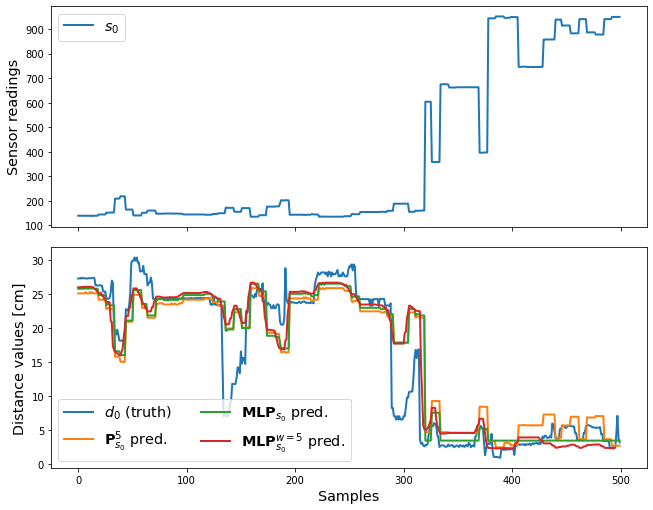

In [20]:
# Generate testing data
X = np.array(dataset[['IR0_meas']].iloc[500:1000])
Y = np.array(dataset[['IR0_cam']].iloc[500:1000])
win_size=5
X_train_win = split_sequence(np.array(X), win_size = win_size)
Y_train_win = np.array(Y)[:X_train_win.shape[0]]

# # Generate Predictions
poly = M_Polyfit_5_s0
pred_Y_poly = poly(X)
MLP = M_s0
pred_Y_MLP = MLP.predict(X)
MLP_win = Mt_s0_w5
pred_Y_MLP_win = MLP_win.predict(X_train_win)

# # Metrics computations
mae_poly = sklearn.metrics.mean_absolute_error(Y, pred_Y_poly)
mae_MLP = sklearn.metrics.mean_absolute_error(Y, pred_Y_MLP)
mae_MLP_win = sklearn.metrics.mean_absolute_error(Y[:-win_size], pred_Y_MLP_win)
print(mae_poly,mae_MLP,mae_MLP_win)

# Plot
fig, axs = plt.subplots(2,sharex=True)
plt.tight_layout()

mk_freq = 10
mk_size = 0
ln_wdth = 2
markers = ['s', 'v', 'o', 'P']

axs[0].plot(X, label=r'$s_{0}$', linewidth = ln_wdth)
axs[1].plot(Y, label=r'$d_{0}$ (truth)', marker = markers[0], markevery = mk_freq, markersize = mk_size, linewidth = ln_wdth)
axs[1].plot(pred_Y_poly, label=r'$\mathbf{P}^{5}_{s_{0}}$ pred.', marker = markers[1], markevery = mk_freq, markersize = mk_size, linewidth = ln_wdth)
axs[1].plot(pred_Y_MLP, label=r'$\mathbf{MLP}_{s_{0}}$ pred.', marker = markers[2], markevery = mk_freq, markersize = mk_size, linewidth = ln_wdth)
axs[1].plot(pred_Y_MLP_win, label='$\mathbf{MLP}^{w=5}_{s_{0}}$ pred.', marker = markers[3], markevery = mk_freq, markersize = mk_size, linewidth = ln_wdth)

axs[0].legend(fontsize="x-large");
axs[1].legend(fontsize="x-large", loc='lower left', ncol=2);
# axs[1].set_ylim([0,25])
axs[0].set_ylabel('Sensor readings',fontsize="x-large")
axs[1].set_xlabel('Samples',fontsize="x-large");
axs[1].set_ylabel('Distance values [cm]',fontsize="x-large")

7/7 [==============================] - 0s 5ms/step
1.0943952235686476 1.0343910606500462 4.444872857865377


<ipython-input-30-696d8abda6ef>:44: MatplotlibDeprecationWarning: Unrecognized location 'top left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  axs[1].legend(fontsize="x-large", loc='top left');


Text(54.125, 0.5, 'Distance values [cm]')

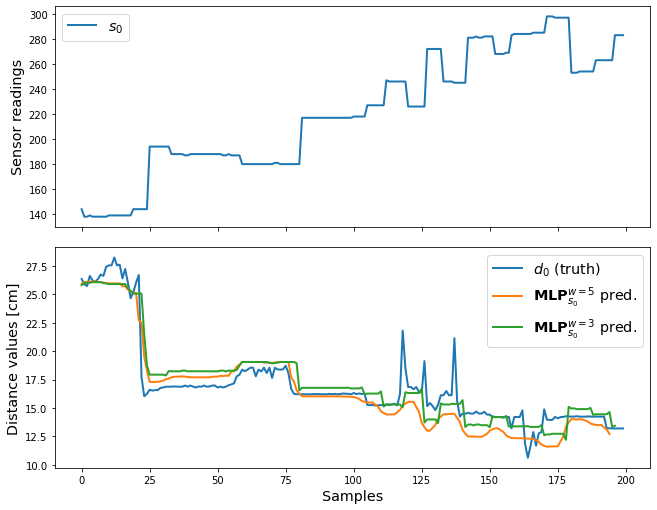

In [30]:
# Generate testing data
X = np.array(dataset[['IR0_meas']].iloc[1200:1400])
Y = np.array(dataset[['IR0_cam']].iloc[1200:1400])
win_size=5
X_train_win_5 = split_sequence(np.array(X), win_size = win_size)
Y_train_win_5 = np.array(Y)[:X_train_win.shape[0]]
win_size=3
X_train_win_3 = split_sequence(np.array(X), win_size = win_size)
Y_train_win_3 = np.array(Y)[:X_train_win.shape[0]]
win_size=1
X_train_win_1 = split_sequence(np.array(X), win_size = win_size)
Y_train_win_1 = np.array(Y)[:X_train_win.shape[0]]

# # Generate Predictions
MLP_win_5 = Mt_s0_w5
pred_Y_MLP_win_5 = MLP_win_5.predict(X_train_win_5)
MLP_win_3 = Mt_s0_w3
pred_Y_MLP_win_3 = MLP_win_3.predict(X_train_win_3)
MLP_win_1 = Mt_s0_w1
pred_Y_MLP_win_1 = MLP_win_1.predict(X_train_win_1)

# # Metrics computations
mae_MLP_win_5 = sklearn.metrics.mean_absolute_error(Y[:-5], pred_Y_MLP_win_5)
mae_MLP_win_3 = sklearn.metrics.mean_absolute_error(Y[:-3], pred_Y_MLP_win_3)
mae_MLP_win_1 = sklearn.metrics.mean_absolute_error(Y[:-1], pred_Y_MLP_win_1)
print(mae_MLP_win_5,mae_MLP_win_3,mae_MLP_win_1)

# Plot
fig, axs = plt.subplots(2,sharex=True)
plt.tight_layout()

mk_freq = 10
mk_size = 0
ln_wdth = 2
markers = ['s', 'v', 'o', 'P']

axs[0].plot(X, label=r'$s_{0}$', linewidth = ln_wdth)
axs[1].plot(Y, label=r'$d_{0}$ (truth)', marker = markers[0], markevery = mk_freq, markersize = mk_size, linewidth = ln_wdth)
axs[1].plot(pred_Y_MLP_win_5, label=r'$\mathbf{MLP}^{w=5}_{s_{0}}$ pred.', marker = markers[1], markevery = mk_freq, markersize = mk_size, linewidth = ln_wdth)
axs[1].plot(pred_Y_MLP_win_3, label=r'$\mathbf{MLP}^{w=3}_{s_{0}}$ pred.', marker = markers[2], markevery = mk_freq, markersize = mk_size, linewidth = ln_wdth)
# axs[1].plot(pred_Y_MLP_win_1, label=r'$\mathbf{MLP}^{w=1}_{s_{0}}$ pred.', marker = markers[3], markevery = mk_freq, markersize = mk_size, linewidth = ln_wdth)

axs[0].legend(fontsize="x-large");
axs[1].legend(fontsize="x-large", loc='top left');
# axs[1].set_ylim([0,25])
axs[0].set_ylabel('Sensor readings',fontsize="x-large")
axs[1].set_xlabel('Samples',fontsize="x-large");
axs[1].set_ylabel('Distance values [cm]',fontsize="x-large")